# loading the data
- i loaded the letters split EMNIST dataset
- i augument the data by 2x
- most of the data i rotate it by -90 and flip horizontal i felt it seems right this way

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms.functional as F


# Define augmentation and normalization for 3 channels
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(45),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(p=0),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.rot90(x, k=270 //90, dims=[1,2])),
    transforms.Lambda(lambda x: 1 - x),  # Invert the image
])

transform = transforms.Compose([
    # transforms.RandomRotation(90),
    # transforms.RandomVerticalFlip(p=0),
    # transforms.Lambda(lambda x: x.rotate(0)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert the image
])

# Load the original EMNIST dataset with 3 channels
train_data = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)

# Load the augmented EMNIST dataset with 3 channels
#augmented_train_data = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=augmentation_transform)

# Concatenate the original and augmented datasets
#train_data = ConcatDataset([train_data, augmented_train_data])

test_data = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

# Create train-test split dataloaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"All classes: {test_data.classes}")
print(len(test_data.classes))
print(test_data.class_to_idx)


100%|██████████| 561753746/561753746 [00:17<00:00, 32070390.47it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
All classes: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


## `Visualization Some Data of images`

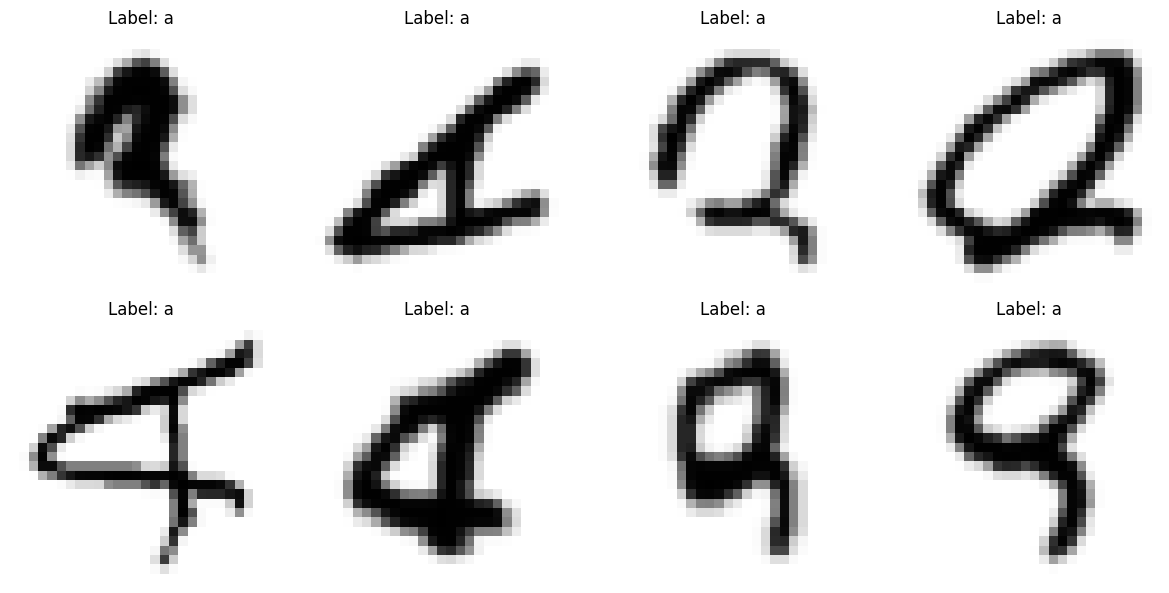

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create DataLoader for the test data
view_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Get the first batch of images and labels
data_iter = iter(view_loader)
images, labels = next(data_iter)



# Convert the images to numpy for plotting
images = images.numpy()

# Normalize images to the range [0, 1] for display
images = np.clip(images, 0, 1)  # Clip values to the range [0, 1] for display

# Plot the images in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Display each image with its label
for i in np.arange(8):
    ax = axes[i]
    ax.imshow(np.squeeze(images[i].transpose(1, 2, 0)), cmap='gray')
    ax.set_title(f'Label: {test_data.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# model


In [3]:
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=27):
        super(AdvancedCNN, self).__init__()
        
        # First Convolution Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel (grayscale), Output: 32 channels
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for stable learning
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64 channels
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second Convolution Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128 channels
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling with 2x2 kernel to downsample
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)  # 50% dropout to avoid overfitting
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Input size after 3x3 convolutions and pooling
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 'num_classes' neurons
        
    def forward(self, x):
        # Convolution + Batch Norm + ReLU + Max Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 1st conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 2nd conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 3rd conv block
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 3 * 3)  # Flattening the 128 x 3 x 3 output to a vector
        
        # Fully Connected Layer + Dropout
        x = F.relu(self.fc1(x))  # FC1 with ReLU activation
        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc2(x)  # Final output layer
        
        return x

# Initialize the model with 27 classes (EMNIST Letters)
model = AdvancedCNN(num_classes=27)
# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss()


# Training

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score ,confusion_matrix
from tqdm import tqdm
# Lists to hold metrics for each epoch
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
f1_scores = []
precisions = []
recalls = []

# Updated train function
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    """
    Train a PyTorch model for one epoch.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        criterion (torch.nn.Module): Loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        device (torch.device): Device to run the training on (e.g., "cpu" or "cuda").
        epoch (int): The current epoch index (0-based).
        num_epochs (int): Total number of epochs for training.

    Global Variables:
        epoch_loss (float): Loss for the current epoch.
        epoch_accuracy (float): Accuracy for the current epoch.
        train_losses (list): List to store training losses for each epoch.
        train_accuracies (list): List to store training accuracies for each epoch.

    Procedure:
        1. Set the model to training mode (`model.train()`).
        2. Initialize running metrics for loss, total samples, and correct predictions.
        3. Iterate over the `train_loader`:
            - Move images and labels to the specified device.
            - Zero the gradients of the optimizer.
            - Perform a forward pass to compute predictions.
            - Compute the loss using the loss function (`criterion`).
            - Perform a backward pass to calculate gradients.
            - Update model parameters using the optimizer.
            - Accumulate the running loss.
            - Calculate and update accuracy metrics.
            - Update the progress bar with current loss and accuracy.
        4. Calculate epoch-level metrics for loss and accuracy.
        5. Append the epoch metrics to `train_losses` and `train_accuracies` for later analysis.
        6. Print the loss and accuracy for the epoch.

    Example:
        >>> # Assuming model, train_loader, optimizer, and criterion are defined
        >>> for epoch in range(num_epochs):
        >>>     train(model, train_loader, criterion, optimizer, device, epoch, num_epochs)

    Notes:
        - The function uses `tqdm` to display a progress bar for each epoch.
        - Ensure `train_losses` and `train_accuracies` are globally defined lists for tracking metrics.
        - Loss and accuracy are printed at the end of each epoch.

    Output:
        - Prints progress bar updates during training with current loss and accuracy.
        - Displays epoch loss and accuracy at the end of the epoch.
    """
    global epoch_loss, epoch_accuracy 
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
        for images, labels in tepoch:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Get the predicted class and calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=running_loss / (len(tepoch)), accuracy=100 * correct / total)

    # Calculate loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    # Store loss and accuracy for plotting later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Updated evaluate function
def evaluate(model, test_loader, criterion, device):
    """
    Evaluate a PyTorch model on a test dataset.

    Parameters:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): Loss function used to compute the evaluation loss.
        device (torch.device): Device to run the evaluation on (e.g., "cpu" or "cuda").

    Global Variables:
        test_loss (float): Loss for the evaluation dataset.
        test_accuracy (float): Accuracy for the evaluation dataset.
        f1 (float): F1-score for the evaluation dataset.
        precision (float): Precision for the evaluation dataset.
        recall (float): Recall for the evaluation dataset.
        cm (numpy.ndarray): Confusion matrix for the evaluation dataset.
        y_pred (list): Predicted labels for the evaluation dataset.
        y_true (list): True labels for the evaluation dataset.
        val_losses (list): List to store evaluation losses across epochs.
        val_accuracies (list): List to store evaluation accuracies across epochs.
        f1_scores (list): List to store F1-scores across epochs.
        precisions (list): List to store precision scores across epochs.
        recalls (list): List to store recall scores across epochs.

    Procedure:
        1. Set the model to evaluation mode (`model.eval()`).
        2. Initialize metrics for running loss, total samples, correct predictions, 
           and lists for predicted and true labels.
        3. Iterate over the `test_loader`:
            - Move images and labels to the specified device.
            - Perform a forward pass to compute predictions.
            - Compute the loss using the loss function (`criterion`).
            - Accumulate the running loss.
            - Calculate and accumulate accuracy metrics.
            - Append predicted and true labels for further metric calculations.
        4. Calculate overall metrics:
            - Loss and accuracy for the test dataset.
            - F1-score, precision, recall using `sklearn.metrics`.
            - Confusion matrix for the evaluation.
        5. Append metrics to global lists for tracking across epochs.
        6. Print evaluation metrics.

    Returns:
        tuple: 
            - test_loss (float): Loss for the evaluation dataset.
            - test_accuracy (float): Accuracy for the evaluation dataset.

    Example:
        >>> # Assuming model, test_loader, and criterion are defined
        >>> test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
        >>> print(f"Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}")

    Notes:
        - The function uses `tqdm` to display a progress bar during evaluation.
        - `f1_score`, `precision_score`, `recall_score`, and `confusion_matrix` are imported from `sklearn.metrics`.
        - Ensure `val_losses`, `val_accuracies`, `f1_scores`, `precisions`, and `recalls` are globally defined lists.
        - The confusion matrix (`cm`) can be visualized or analyzed further.

    Output:
        - Prints progress bar updates with current loss and accuracy.
        - Displays overall evaluation metrics (loss, accuracy, F1-score, precision, recall).
    """
    global test_accuracy, test_loss, f1, precision, recall ,cm , y_pred ,y_true 
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        with tqdm(test_loader, desc="Evaluating", unit="batch") as tepoch:
            for images, labels in tepoch:
                # Move data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Update running loss
                running_loss += loss.item()

                # Get the predicted class and calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                tepoch.set_postfix(loss=running_loss / (len(tepoch)), accuracy=100 * correct / total)

                # Append predicted and true labels for metric calculation
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

    # Calculate loss and accuracy for the evaluation
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    # Calculate F1, precision, and recall
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)


    # Store evaluation metrics for plotting
    val_losses.append(test_loss)
    val_accuracies.append(test_accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    print(f"F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return test_loss, test_accuracy

In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    # Pass num_epochs to the train function
    train(model, train_loader, criterion, optimizer, device, epoch, num_epochs)
    evaluate(model, test_loader, criterion, device)


Epoch 1/5: 100%|██████████| 975/975 [00:21<00:00, 44.62batch/s, accuracy=86.1, loss=0.437]


Epoch 1 - Loss: 0.4373, Accuracy: 86.13%


Evaluating: 100%|██████████| 163/163 [00:03<00:00, 52.86batch/s, accuracy=92.7, loss=0.218]


Test - Loss: 0.2183, Accuracy: 92.73%
F1-score: 0.9269, Precision: 0.9277, Recall: 0.9273


Epoch 2/5: 100%|██████████| 975/975 [00:21<00:00, 45.97batch/s, accuracy=92.2, loss=0.232] 


Epoch 2 - Loss: 0.2325, Accuracy: 92.22%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 59.28batch/s, accuracy=93.4, loss=0.2]  


Test - Loss: 0.1996, Accuracy: 93.38%
F1-score: 0.9334, Precision: 0.9347, Recall: 0.9338


Epoch 3/5: 100%|██████████| 975/975 [00:20<00:00, 47.56batch/s, accuracy=93.3, loss=0.198] 


Epoch 3 - Loss: 0.1981, Accuracy: 93.32%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 58.69batch/s, accuracy=94.1, loss=0.174] 


Test - Loss: 0.1740, Accuracy: 94.06%
F1-score: 0.9405, Precision: 0.9417, Recall: 0.9406


Epoch 4/5: 100%|██████████| 975/975 [00:20<00:00, 47.77batch/s, accuracy=93.9, loss=0.177] 


Epoch 4 - Loss: 0.1773, Accuracy: 93.92%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 59.27batch/s, accuracy=94.2, loss=0.166] 


Test - Loss: 0.1663, Accuracy: 94.24%
F1-score: 0.9420, Precision: 0.9432, Recall: 0.9424


Epoch 5/5: 100%|██████████| 975/975 [00:20<00:00, 47.81batch/s, accuracy=94.3, loss=0.163] 


Epoch 5 - Loss: 0.1629, Accuracy: 94.33%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 55.96batch/s, accuracy=94.5, loss=0.16]  


Test - Loss: 0.1604, Accuracy: 94.48%
F1-score: 0.9445, Precision: 0.9458, Recall: 0.9448


In [8]:
torch.save(model.state_dict(), "abdo.pth")

# save the model to ONNX

In [9]:
%pip install onnx
%pip install onnxruntime

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch.onnx
from torch import nn

# Function to save the model in ONNX format
def save_model_to_onnx(model, file_path, input_sample):
    """
    Save a PyTorch model in ONNX format.

    Parameters:
        model (torch.nn.Module): The PyTorch model to export.
        file_path (str): The file path where the ONNX model will be saved.
        input_sample (torch.Tensor): A sample input tensor that matches the input dimensions
            of the model. Used for tracing the model during export.

    Procedure:
        1. Set the model to evaluation mode (`model.eval()`).
        2. Use `torch.onnx.export` to export the model:
           - Include model parameters.
           - Optimize for constant folding if possible.
           - Specify ONNX opset version (default: 12).
           - Define input and output names.
           - Enable dynamic axes for flexibility in batch size.

    Parameters for `torch.onnx.export`:
        - `model`: The PyTorch model instance.
        - `input_sample`: Input tensor for tracing the model.
        - `file_path`: Destination file path for the ONNX model.
        - `export_params`: Exports all trained parameters along with the model.
        - `opset_version`: Specifies the ONNX operator set version to use.
        - `do_constant_folding`: Enables optimization by constant folding.
        - `input_names`: Names the input layers for ONNX representation.
        - `output_names`: Names the output layers for ONNX representation.
        - `dynamic_axes`: Allows dynamic batch size for input and output layers.

    Example:
        >>> # Define a model and a sample input
        >>> model = MyModel()
        >>> dummy_input = torch.randn(1, 1, 28, 28).to(device)
        >>> onnx_file_path = "emnist.onnx"
        >>> save_model_to_onnx(model, onnx_file_path, dummy_input)
        >>> print(f"ONNX model saved to {onnx_file_path}")

    Notes:
        - Ensure the input tensor matches the model's input size and shape.
        - The exported ONNX model can be used in frameworks like ONNX Runtime, TensorRT, or other ONNX-compatible tools.
    """
    model.eval()  # Set the model to evaluation mode
    # Export the model to ONNX
    torch.onnx.export(model,  # Model to export
                      input_sample,  # Sample input for tracing
                      file_path,  # Path where the model will be saved
                      export_params=True,  # Store trained parameters
                      opset_version=12,  # Specify the ONNX opset version
                      do_constant_folding=True,  # Optimization for constant folding
                      input_names=["input"],  # Name of the input layer
                      output_names=["output"],  # Name of the output layer
                      dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})  # Allow variable batch sizes

    print(f"Model saved to {file_path}")

dummy_input = torch.randn(1,1, 28, 28).to(device)  # Grayscale image

# Define the path to save the ONNX model
onnx_file_path = "emnist.onnx"

# Save the model in ONNX format
save_model_to_onnx(model, onnx_file_path, dummy_input)


Model saved to emnist.onnx


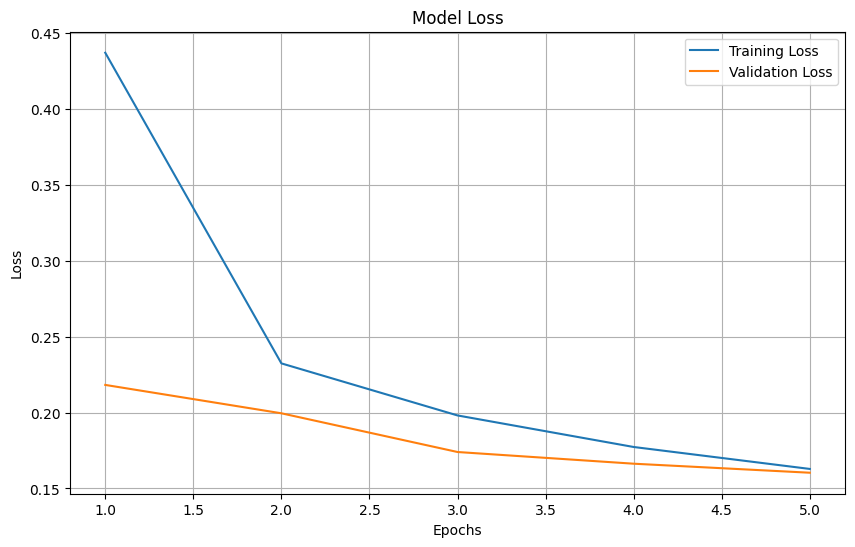

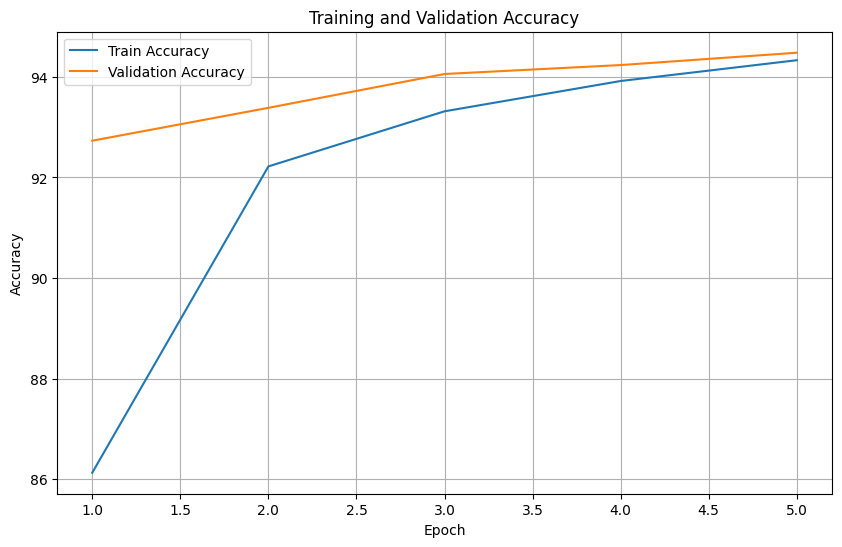

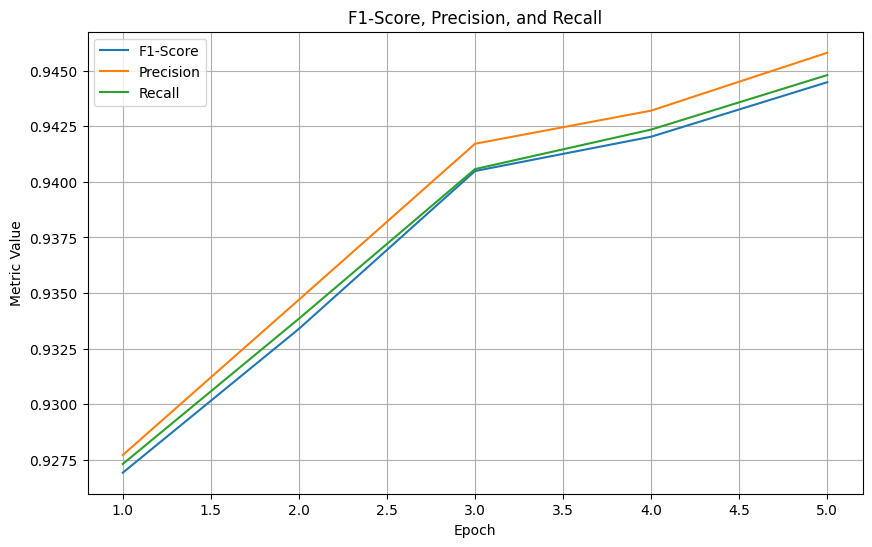

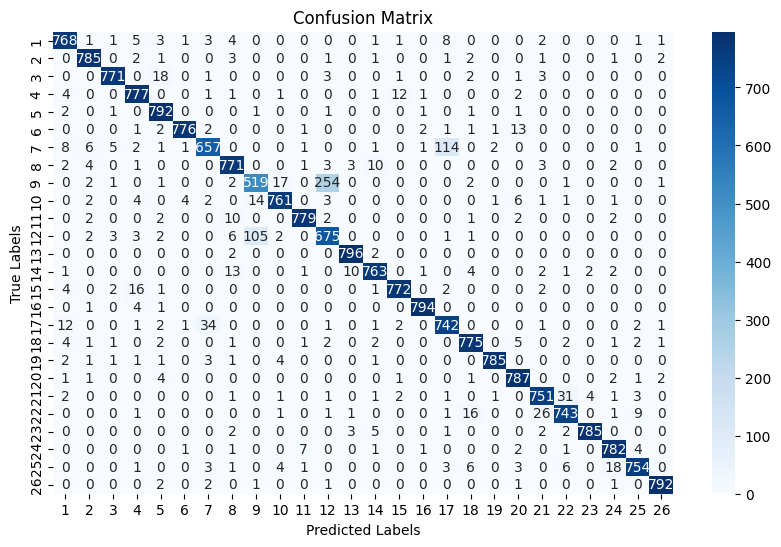

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of epochs
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



# ... (Your existing code for training and evaluation)

# Assuming you have a list of training and validation accuracies (e.g., 'train_accuracies' and 'val_accuracies')
# and a list of epochs (e.g., 'epochs')

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-score, precision, and recall (assuming you have lists of these metrics)
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, label='F1-Score')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('F1-Score, Precision, and Recall')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import KFold

def cross_validation(dataset, model_class, k=5, epochs=4):
    """
    Perform k-fold cross-validation on a given dataset and model class.

    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to use for cross-validation.
        model_class (type): A callable class that returns a model instance when invoked.
        k (int, optional): The number of folds for cross-validation. Default is 5.
        epochs (int, optional): The number of training epochs for each fold. Default is 4.

    Returns:
        tuple:
            - fold_results (list): A list of dictionaries containing evaluation metrics 
              (accuracy, precision, recall, and F1 score) for each fold.
            - overall_results (dict): A dictionary containing the aggregated evaluation metrics 
              (accuracy, precision, recall, and F1 score) across all folds.

    Procedure:
        1. Split the dataset into k folds using sklearn's KFold.
        2. For each fold:
            - Create training and validation subsets based on the current split.
            - Initialize a new instance of the model for the fold.
            - Define an optimizer and loss function for the model.
            - Train the model using the training subset for the specified number of epochs.
            - Evaluate the model on the validation subset to compute metrics:
                - Accuracy
                - Precision
                - Recall
                - F1 Score
            - Store the fold's metrics in `fold_results`.
        3. Compute the overall metrics as the mean of the metrics across all folds.

    Example:
        >>> # Assuming `train_dataset` and `val_dataset` are pre-defined
        >>> full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
        >>> results, overall = cross_validation(full_dataset, GTSRBClassifier, k=5, epochs=4)
        >>> print("Overall Results:", overall)
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    # Iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        # Create subsets for training and validation
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        # Create dataloaders for each fold
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Initialize a new model for each fold
        model = model_class().to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Train the model for the current fold
        training_loss, validation_loss = train(model, train_loader, val_loader, optimizer, loss_fn, None, epochs)

        # Evaluate the model on validation set
        val_labels, val_preds, accuracy, precision, recall, f1, _, _ = Testing(model, val_loader)

        # Store results for this fold
        fold_results.append({
            "fold": fold + 1,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        })

        print(f"Fold {fold + 1} Results: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")

    # Aggregate and display overall results
    overall_results = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1_score": np.mean([result["f1_score"] for result in fold_results]),
    }

    print("Overall Cross-Validation Results:")
    print(f"Accuracy: {overall_results['accuracy']:.4f}")
    print(f"Precision: {overall_results['precision']:.4f}")
    print(f"Recall: {overall_results['recall']:.4f}")
    print(f"F1-Score: {overall_results['f1_score']:.4f}")

    return fold_results, overall_results

# Combine training and validation datasets for cross-validation
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Run cross-validation
results, overall = cross_validation(full_dataset, GTSRBClassifier, k=5, epochs=4)